# Avaliação - Regressão
## Inferir custos médicos do plano de saúde a partir do arquivo insurance.csv

### Carregamento dos dados

In [137]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.pyplot as plt
import umap.umap_ as umap
import umap.plot

In [138]:
insurance = pd.read_csv(Path('insurance.csv'))
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [139]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### Visualizando os dados

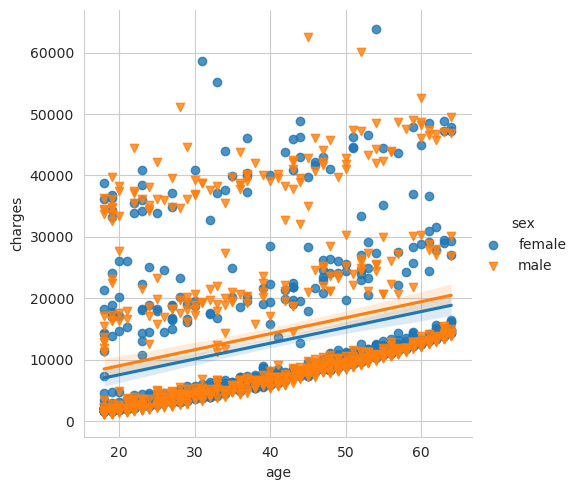

In [140]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
sns.set_style('whitegrid')
sns.lmplot(x ='age', y ='charges', data = insurance, hue ='sex', markers =['o', 'v'])

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


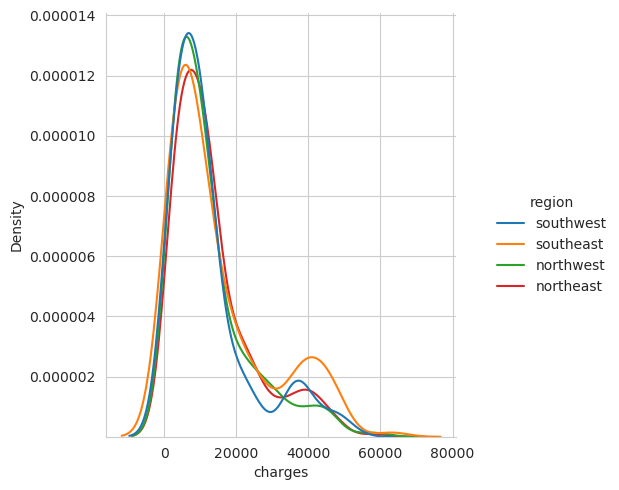

In [141]:
sns.displot(x='charges', data=insurance, hue='region', kind='kde')

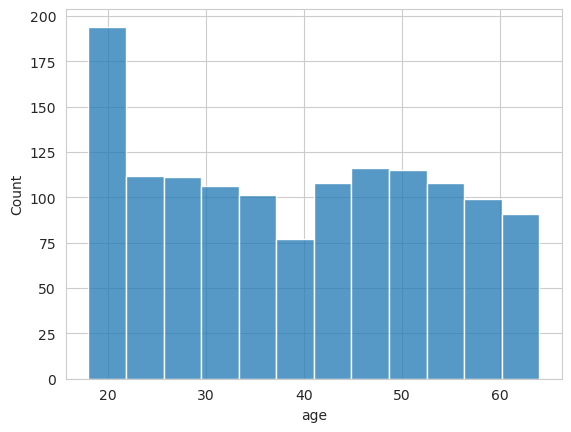

In [142]:
sns.histplot(insurance['age'])

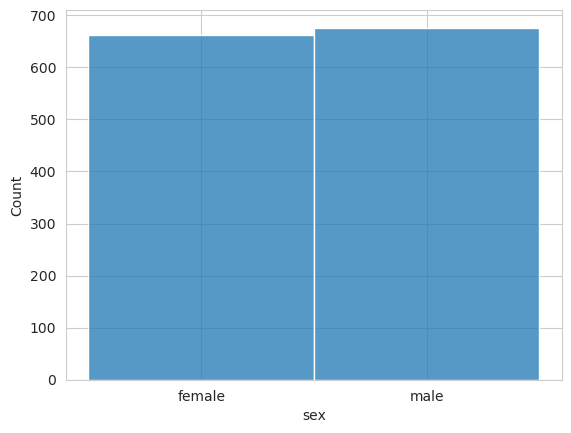

In [143]:
sns.histplot(insurance['sex'])

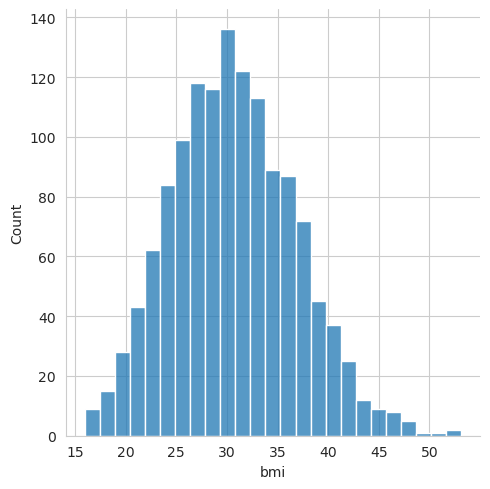

In [144]:
sns.displot(insurance['bmi'])

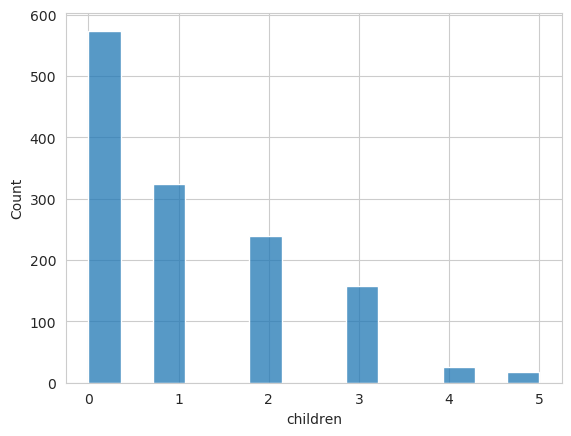

In [145]:
sns.histplot(insurance['children'])

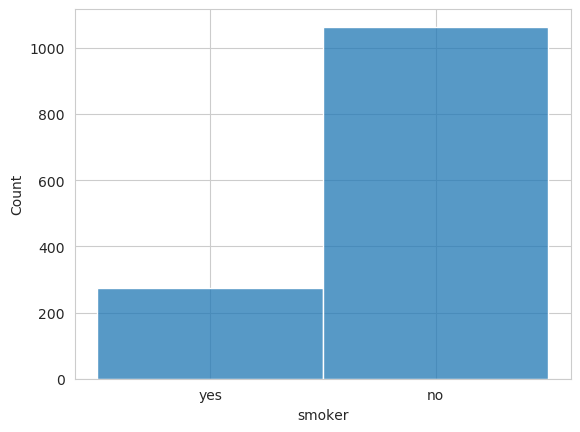

In [146]:
sns.histplot(insurance['smoker'])

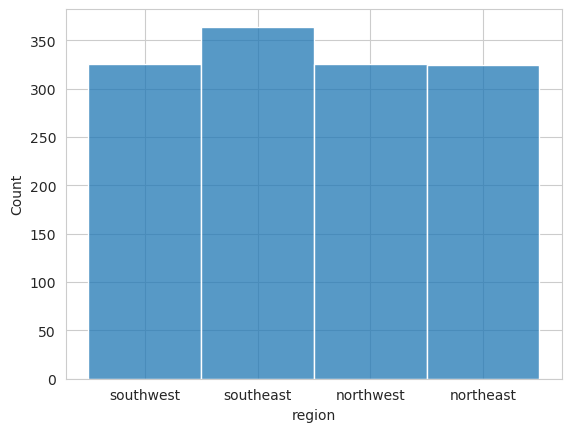

In [147]:
sns.histplot(insurance['region'])

In [148]:
#normalizar os valores, por exemplo min-max (0-1) para tirar os valores negativos
#transformer = MaxAbsScaler().fit(insurance['charges'].values.reshape(-1,1))
#transformer = transformer.transform(insurance['charges'].values.reshape(-1,1))
#insurance['charges'] = transformer.reshape(-1)
#sns.displot(insurance['charges'], kind = 'kde')

### Preparação dos dados

In [149]:
#função para reverter o pandas.get_dummies()
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [150]:
one_hot_encoding = pd.get_dummies(insurance[['sex', 'region', 'smoker']])
one_hot_encoding.head()

,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker_no,smoker_yes
0,1,0,0,0,0,1,0,1
1,0,1,0,0,1,0,1,0
2,0,1,0,0,1,0,1,0
3,0,1,0,1,0,0,1,0
4,0,1,0,1,0,0,1,0


In [151]:
insurance = insurance.drop(['sex', 'region', 'smoker'], axis = 1)

In [152]:
insurance = pd.concat([insurance, one_hot_encoding], axis=1)
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   bmi               1338 non-null   float64
 2   children          1338 non-null   int64  
 3   charges           1338 non-null   float64
 4   sex_female        1338 non-null   uint8  
 5   sex_male          1338 non-null   uint8  
 6   region_northeast  1338 non-null   uint8  
 7   region_northwest  1338 non-null   uint8  
 8   region_southeast  1338 non-null   uint8  
 9   region_southwest  1338 non-null   uint8  
 10  smoker_no         1338 non-null   uint8  
 11  smoker_yes        1338 non-null   uint8  
dtypes: float64(2), int64(2), uint8(8)
memory usage: 52.4 KB


In [153]:
train_set, test_set = train_test_split(insurance, test_size=0.2, random_state=42)
print(len(train_set), "train +", len(test_set), "test")

1070 train + 268 test


In [154]:
y_train, y_test = train_set['charges'], test_set['charges']

In [155]:
x_train, x_test = train_set.drop(['charges'], axis=1), test_set.drop(['charges'], axis=1)
x_train.head()

,age,bmi,children,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker_no,smoker_yes
560,46,19.95,2,1,0,0,1,0,0,1,0
1285,47,24.32,0,1,0,1,0,0,0,1,0
1142,52,24.86,0,1,0,0,0,1,0,1,0
969,39,34.32,5,1,0,0,0,1,0,1,0
486,54,21.47,3,1,0,0,1,0,0,1,0


### Treinamento e avaliação

In [156]:
lin_reg = LinearRegression() 
#lin_reg = LinearRegression(positive=True) 
lin_reg.fit(x_train,y_train)
resultado=lin_reg.predict(x_test)

In [157]:
resultado[0]

8969.550274436167

In [158]:
#o melhor valor é 0.0
print(mean_squared_error(y_test, resultado))

33596915.85136147


In [159]:
#o melhor valor é 0.0
print(mean_absolute_error(y_test, resultado))

4181.194473753644


In [160]:
#o melhor valor é 1.0
print(r2_score(y_test, resultado))

0.7835929767120723


In [161]:
print(f'Valor mínimo: {min(y_train)}')
print(f'Valor máximo: {max(y_train)}')
print(f'Média: {np.mean(y_train)}')

Valor mínimo: 1121.8739
Valor máximo: 62592.87309
Média: 13346.089736364485


In [162]:
print(f'Valor mínimo: {min(resultado)}')
print(f'Valor máximo: {max(resultado)}')
print(f'Média: {np.mean(resultado)}')
print(f'Intercept: {lin_reg.intercept_}')

Valor mínimo: -1545.5718493380973
Valor máximo: 40920.29151164595
Média: 13187.557732494482
Intercept: -574.5357125101964


In [163]:
lin_reg.coef_

array([ 2.56975706e+02,  3.37092552e+02,  4.25278784e+02,  9.29584582e+00,
       -9.29584582e+00,  4.59585244e+02,  8.89079180e+01, -1.98279052e+02,
       -3.50214110e+02, -1.18255644e+04,  1.18255644e+04])

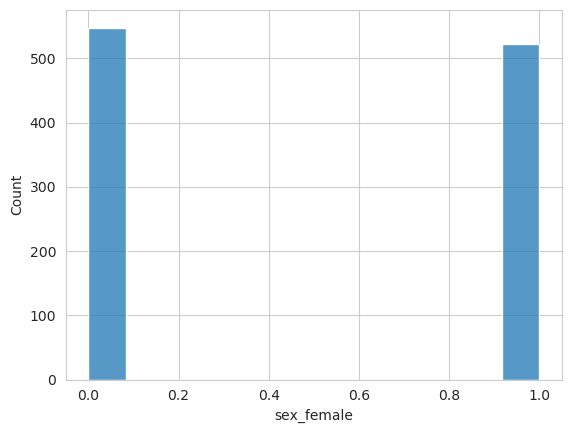

In [164]:
#fazer histograma dos atributos mais e menos importantes, respectivamente
sns.histplot(x_train['sex_female'])

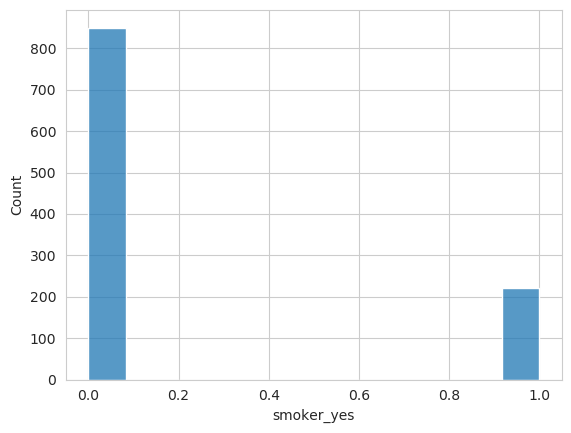

In [165]:
sns.histplot(x_train['smoker_yes'])

In [166]:
def cria_label(valor):
    if valor <= 10000:
        return '$0-10,000'
    elif valor in range(10001,20001):
        return '$10,001-20,000'
    elif valor in range(20001,30001):
        return '$20,001-30,000'
    elif valor in range(30001,40001):
        return '$30,001-40,000'
    elif valor in range(40001,50001):
        return '$40,001-50,000'
    elif valor in range(50001,60001):
        return '$50,001-60,000'
    else:
        return '$60,001+'

insurance['charges'] = [round(x) for x in insurance['charges']]
for index in range(0, len(insurance)):
    insurance.at[index, 'labels'] = cria_label(insurance.at[index, 'charges'])

In [167]:
insurance['labels'].value_counts()

$0-10,000         712
$10,001-20,000    353
$20,001-30,000    111
$30,001-40,000     83
$40,001-50,000     72
$50,001-60,000      4
$60,001+            3
Name: labels, dtype: int64

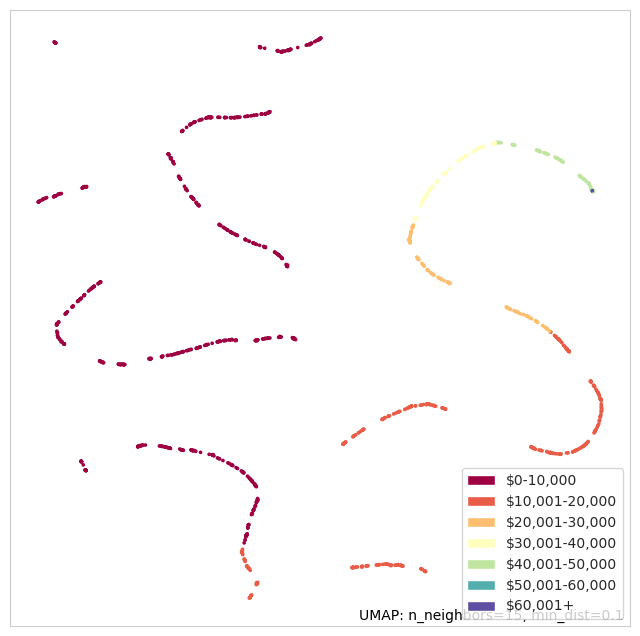

In [172]:
#Gráfico de cluster com rótulos - UMPA

mapper = umap.UMAP().fit(insurance['charges'].values.reshape(-1,1))
sent_labels = insurance['labels']
sent_labels.value_counts()
umap.plot.points(mapper, labels=sent_labels)

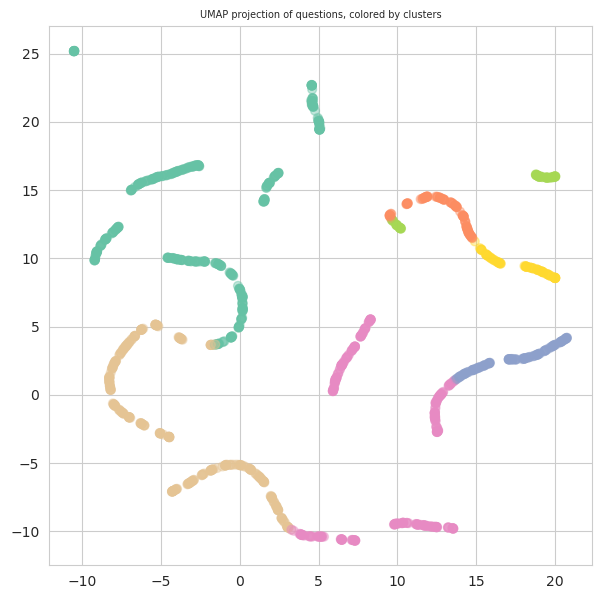

In [174]:
#Gráfico de cluster sem rótulos - UMPA

umap_embedder = umap.UMAP()
umap_features = umap_embedder.fit_transform(insurance['charges'].values.reshape(-1,1))

# Choose number of clusters and colormap
n_clusters=7
cmap = plt.get_cmap("Set2")
fig = plt.figure(figsize=(7, 7))


# Fit clustering algorithm to our vectorized features
clus = KMeans(n_clusters=n_clusters, random_state=10)
clusters = clus.fit_predict(insurance['charges'].values.reshape(-1,1))

# Plot the dimentionality reduced features on a 2D plane
plt.scatter(umap_features[:, 0], umap_features[:, 1], 
            c=[cmap(x/n_clusters) for x in clusters], s=40, alpha=.4)
plt.title('UMAP projection of questions, colored by clusters', fontsize=7);